# Demonstration of `numpyro-oop` usage



<a target="_blank" href="https://colab.research.google.com/github/ag-perception-wallis-lab/numpyro-oop/blob/update-examples/examples/demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
!pip install numpyro-oop
# you may be requested to restart the kernel, do so and rerun all cells.

In [1]:
import warnings

warnings.filterwarnings("ignore")

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import pandas as pd
from numpyro.diagnostics import hpdi
from numpyro.infer.reparam import LocScaleReparam

from numpyro_oop import BaseNumpyroModel

numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

## Basic regression example

In [2]:
# example from https://num.pyro.ai/en/stable/tutorials/bayesian_regression.html

DATASET_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
dset = pd.read_csv(DATASET_URL, sep=";")
dset.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [3]:
def standardize(x):
    return (x - x.mean()) / x.std()


dset["AgeScaled"] = dset.MedianAgeMarriage.pipe(standardize)
dset["MarriageScaled"] = dset.Marriage.pipe(standardize)
dset["DivorceScaled"] = dset.Divorce.pipe(standardize)

### Defining the model class

The basic idea of `numpyro-oop` is that the user should define a new class that inherits from `BaseNumpyroModel`.
This new class mainly needs to define the `model` method.
Then all other sampling and prediction steps are handled by `numpyro-oop`, or related libraries (e.g. `arviz`).

Here's a demonstration of a basic `RegressionModel` class plus `model` definition for the data above.
See the [numpyro demo here](https://num.pyro.ai/en/stable/tutorials/bayesian_regression.html) for more.

In [4]:
class RegressionModel(BaseNumpyroModel):
    def model(self, data=None, sample_conditional=True):
        a = numpyro.sample("a", dist.Normal(0.0, 0.2))
        bM = numpyro.sample("bM", dist.Normal(0.0, 0.5))
        M = bM * data.MarriageScaled.values
        sigma = numpyro.sample("sigma", dist.Exponential(1.0))
        mu = numpyro.deterministic("mu", a + M)

        if sample_conditional:
            obs = data.DivorceScaled.values
        else:
            obs = None

        numpyro.sample("obs", dist.Normal(mu, sigma), obs=obs)

We can now instantiate this class, adding the dataset and a random seed.


In [5]:
m1 = RegressionModel(data=dset, seed=42)

We can also render a graphical representation of our model (requires `graphviz` package).

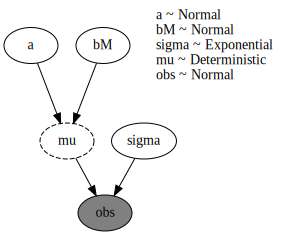

In [6]:
m1.render()

### Sampling from the posterior

Now sample from the model (using the NUTS sampler, by default):

In [7]:
m1.sample(generate_arviz_data=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [8]:
m1.mcmc.print_summary(0.90)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.11     -0.00     -0.19      0.18   3778.66      1.00
        bM      0.35      0.13      0.35      0.14      0.57   3550.46      1.00
     sigma      0.95      0.10      0.94      0.80      1.12   3511.26      1.00

Number of divergences: 0


### Posterior over the regression line

Now we can generate the posterior predictive distribution for the mean prediction ("regression line") by
using the `"mu"` variable of the model:

In [9]:
preds = m1.predict()
mean_mu = preds["mu"].mean(axis=0)
hpdi_mu = hpdi(preds["mu"], 0.9)

[Text(0.5, 0, 'Marriage rate'),
 Text(0, 0.5, 'Divorce rate'),
 Text(0.5, 1.0, 'Regression line with 90% CI')]

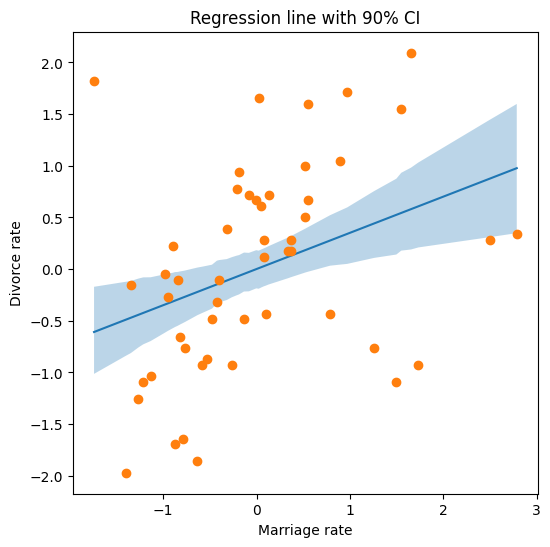

In [10]:
# https://num.pyro.ai/en/stable/tutorials/bayesian_regression.html#Posterior-Distribution-over-the-Regression-Parameters
def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    divorce = dset.DivorceScaled.values[idx]

    # Plot
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(marriage, mean)
    ax.plot(marriage, divorce, "o")
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax


ax = plot_regression(dset.MarriageScaled.values, mean_mu, hpdi_mu)
ax.set(
    xlabel="Marriage rate", ylabel="Divorce rate", title="Regression line with 90% CI"
)

### Prior predictive distribution

We can sample observed values from the prior predictive distribution.
Note here we're sampling from `"obs"` not `"mu"`, so the samples include the Normal error assumed by the model.

Here, it becomes important to set `obs=None` in the model so that the `Predictive` method from Numpyro behaves as expected.

[Text(0.5, 0, 'Marriage rate'),
 Text(0, 0.5, 'Divorce rate'),
 Text(0.5, 1.0, 'Prior predictions with 90% CI')]

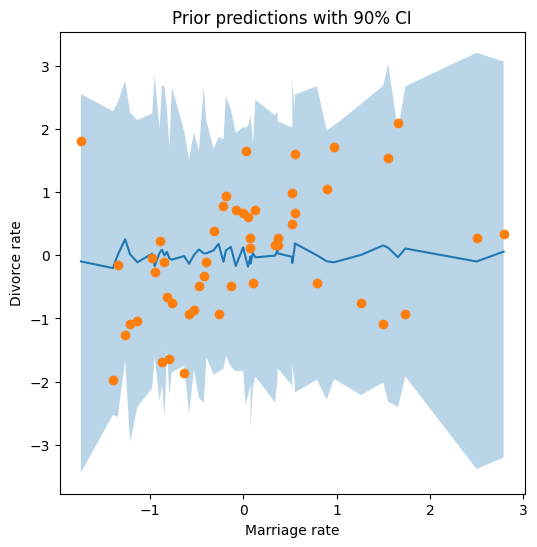

In [11]:
preds = m1.predict(prior=True, model_kwargs={"sample_conditional": False})
mean_prior_pred = preds["obs"].mean(axis=0)
hpdi_prior_pred = hpdi(preds["obs"], 0.9)
ax = plot_regression(dset.MarriageScaled.values, mean_prior_pred, hpdi_prior_pred)
ax.set(
    xlabel="Marriage rate", ylabel="Divorce rate", title="Prior predictions with 90% CI"
)

If instead the observations are not set to `None` (here, by passing `sample_conditional=True` instead of `False`), the `predict` method (which calls Numpyro's `Predictive`) will not behave as expected:

[Text(0.5, 0, 'Marriage rate'),
 Text(0, 0.5, 'Divorce rate'),
 Text(0.5, 1.0, 'Prior predictions with 90% CI')]

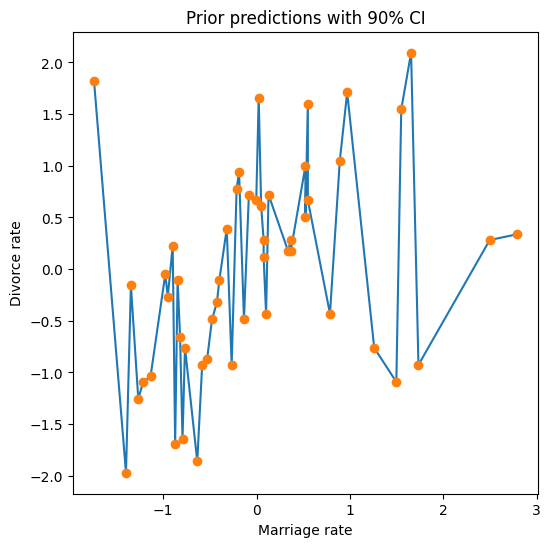

In [12]:
preds = m1.predict(
    prior=True, model_kwargs={"sample_conditional": True}
)  ## incorrect use!
mean_prior_pred = preds["obs"].mean(axis=0)
hpdi_prior_pred = hpdi(preds["obs"], 0.9)
ax = plot_regression(dset.MarriageScaled.values, mean_prior_pred, hpdi_prior_pred)
ax.set(
    xlabel="Marriage rate", ylabel="Divorce rate", title="Prior predictions with 90% CI"
)

### Posterior predictive distribution

As for the prior predictive distribution, we can sample observations from the posterior distribution (here, simply use the default value of `prior=False` for the `predict` method):

[Text(0.5, 0, 'Marriage rate'),
 Text(0, 0.5, 'Divorce rate'),
 Text(0.5, 1.0, 'Posterior predictions with 90% CI')]

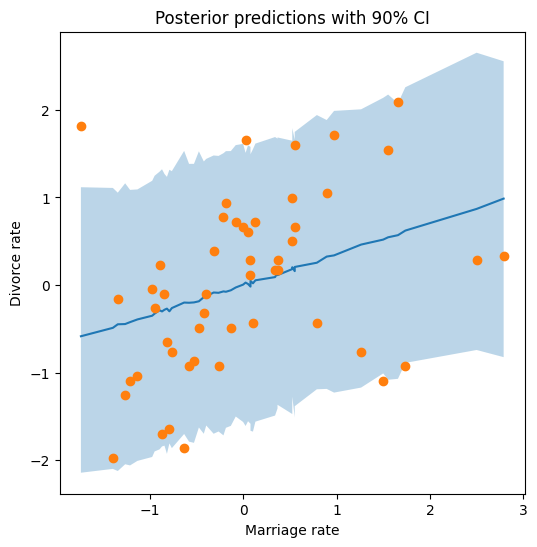

In [13]:
preds = m1.predict(prior=False, model_kwargs={"sample_conditional": False})
mean_post_pred = preds["obs"].mean(axis=0)
hpdi_post_pred = hpdi(preds["obs"], 0.9)
ax = plot_regression(dset.MarriageScaled.values, mean_post_pred, hpdi_post_pred)
ax.set(
    xlabel="Marriage rate",
    ylabel="Divorce rate",
    title="Posterior predictions with 90% CI",
)

### Arviz data

`numpryo-oop` also allows us to generate data in the [arviz](https://python.arviz.org/en/stable/index.html) format.
Note that we passed `generate_arviz_data=True` to the `sample` method above.
This means we already have an arviz data object for our model:

In [14]:
m1.arviz_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

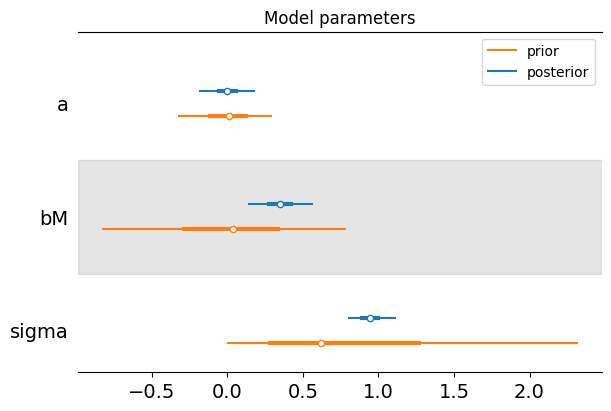

In [15]:
# can now use arviz's nice features:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout="constrained")
ax = az.plot_forest(
    [m1.arviz_data["posterior"], m1.arviz_data["prior"]],
    model_names=["posterior", "prior"],
    kind="forestplot",
    var_names=["a", "bM", "sigma"],
    hdi_prob=0.9,
    combined=True,
    ridgeplot_overlap=1.5,
    ax=ax,
)
ax[0].set_title("Model parameters")
plt.show()

Note that you can also generate arviz data from a fitted model later by simply calling the `generate_arviz_data` method directly, which we demo below.

## Hierarchical inference example: Eight schools

Here we use the popular Eight schools dataset to demonstrate the implementation of a hierarchical model and the use of plates with `numpyro-oop`.
The reference implementation in the `numpyro` docs is here: https://num.pyro.ai/en/stable/getting_started.html#a-simple-example-8-schools

The dataset was collected by Alderman and Powers (1979) and reported in Rubin (1981).
It was described by Sturtz et al (2005):

> The Scholastic Aptitude Test (SAT) measures the aptitude of high-schoolers in order to help colleges to make admissions decisions. It is divided into two parts, verbal (SAT-V) and mathematical (SAT-M). Our data comes from the SAT-V (Scholastic Aptitude Test-Verbal) on eight different high schools, from an experiment conducted in the late 1970s. SAT-V is a standard multiple choice test administered by the Educational Testing Service. This Service was interested in the effects of coaching programs for each of the selected schools.
>
> The study included coached and uncoached pupils, about sixty in each of the eight different schools; see Rubin (1981). All of them had already taken the PSAT (Preliminary SAT) which results were used as covariates. For each school, the estimated treatment effect and the standard error of the effect estimate are given. These are calculated by an analysis of covariance adjustment appropriate for a completely randomized experiment (Rubin 1981). This example was analyzed using a hierarchical normal model in Rubin (1981) and Gelman, Carlin, Stern, and Rubin (2003, Section 5.5).

#### References

Alderman, D., & Powers, D. (1979). The effects of special preparation on SAT-Verbal scores. Research Report 79–1. Educational Testing Service, Princeton, N.J.

Rubin, D. B. (1981). Estimation in Parallel Randomized Experiments. *Journal of Educational Statistics, 6*(4), 377–400.

Sturtz, S., Ligges, U., & Gelman, A. (2005). R2WinBUGS: A Package for Running WinBUGS from R. Journal of Statistical Software, 12(3). https://doi.org/10.18637/jss.v012.i03


In [16]:
df = pd.DataFrame(
    {
        "school": ["A", "B", "C", "D", "E", "F", "G", "H"],
        "treatment_effect": [28.39, 7.94, -2.75, 6.82, -0.64, 0.63, 18.01, 12.16],
        "treatment_sd": [14.9, 10.2, 16.3, 11.0, 9.4, 11.4, 10.4, 17.6],
    }
)
df

,school,treatment_effect,treatment_sd
0,A,28.39,14.9
1,B,7.94,10.2
2,C,-2.75,16.3
3,D,6.82,11.0
4,E,-0.64,9.4
5,F,0.63,11.4
6,G,18.01,10.4
7,H,12.16,17.6


`numpyro-oop` allows us to specify grouping variables in the dataframe.
Each grouping variable will be used to create a `numpyro.plate` object stored internally in the model class.
The `model` definition can then use this plate object in the standard context.
The advantage here is that we can verify that dimensions and labels correspond.

To see how the plate structure will correspond to the variable school, let's call this first on the base class:

In [17]:
tmp = BaseNumpyroModel(seed=1, data=df, group_variables="school")
tmp.plate_dicts

{'school': {'coords': {0: 'A',
   1: 'B',
   2: 'C',
   3: 'D',
   4: 'E',
   5: 'F',
   6: 'G',
   7: 'H'},
  'dim': -1,
  'size': 8,
  'idx': array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int8),
  'plate': <numpyro.primitives.plate at 0x7bc43cd3ecb0>}}

We can then make use of this plate with the context `self.plate_dicts["school"]["plate"]` in the body of our model:

In [18]:
class EightSchools(BaseNumpyroModel):
    def model(self, data=None, sample_conditional=True):
        y = data.treatment_effect.values
        sigma = data.treatment_sd.values
        mu = numpyro.sample("mu", dist.Normal(0, 5))
        tau = numpyro.sample("tau", dist.HalfCauchy(5))
        with self.plate_dicts["school"]["plate"]:
            theta = numpyro.sample("theta", dist.Normal(mu, tau))

        if sample_conditional:
            obs = y
        else:
            obs = None
        numpyro.sample(
            "obs", dist.Normal(theta[self.plate_dicts["school"]["idx"]], sigma), obs=obs
        )  # could also include in the plate context; used to demo "idx" here.

Note that this is equivalent to writing

```python
with numpyro.plate("school", size=8, dim=-1):
  ...
```

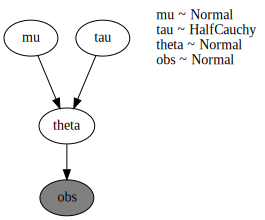

In [19]:
m2 = EightSchools(seed=258, data=df, group_variables="school")
m2.render()  # fails to render plate

Note that while the `numpyro-oop` plate wrapper (`self.plate_dicts["school"]["plate"]`) works for sampling (see below), it does cause problems with rendering the graphical model (no plate is shown).

In [20]:
m2.sample()
m2.mcmc.print_summary(0.9)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      4.45      3.28      4.49     -0.89      9.88    577.17      1.01
       tau      4.41      3.20      3.49      0.78      8.91    344.83      1.01
  theta[0]      6.74      6.04      6.20     -2.28     16.18    917.54      1.00
  theta[1]      5.13      5.00      5.03     -2.79     13.32   1018.70      1.01
  theta[2]      3.80      5.77      4.06     -4.90     13.43   1098.91      1.00
  theta[3]      4.77      5.19      4.77     -2.96     13.43   1257.28      1.00
  theta[4]      3.58      5.20      3.94     -4.82     12.16   1152.23      1.00
  theta[5]      3.92      5.16      4.14     -3.84     12.53   1052.61      1.00
  theta[6]      6.75      5.44      6.17     -1.80     15.33    809.55      1.00
  theta[7]      5.18      5.74      4.96     -3.73     14.46   1413.14      1.01

Number of divergences: 71


### Reparameterized Eight Schools

Note the high number of divergences in the model sampled above.
This is caused by the model's direct inheritance between the upper and lower levels of the hierarchy (called a "centered" parameterization).
This issue can be solved by using a "non-centered" parameterization.
(For more detail on reparameterization see [here](https://mc-stan.org/docs/2_18/stan-users-guide/reparameterization-section.html)).

Reparameterization like this can be handled conveniently by Numpyro's [`reparam` handler](https://num.pyro.ai/en/stable/handlers.html#reparam).
This can be even more conveniently achieved in `numpyro-oop`:

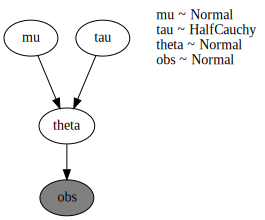

In [21]:
class EightSchools(BaseNumpyroModel):
    def model(self, data=None, sample_conditional=True):
        y = data.treatment_effect.values
        sigma = data.treatment_sd.values
        mu = numpyro.sample("mu", dist.Normal(0, 5))
        tau = numpyro.sample("tau", dist.HalfCauchy(5))
        with self.plate_dicts["school"]["plate"]:
            theta = numpyro.sample("theta", dist.Normal(mu, tau))

        if sample_conditional:
            obs = y
        else:
            obs = None
        numpyro.sample(
            "obs", dist.Normal(theta[self.plate_dicts["school"]["idx"]], sigma), obs=obs
        )  # could also include in the plate context; used to demo "idx" here.

    def generate_reparam_config(self):
        # a dictionary mapping site names to a Reparam.
        # see https://num.pyro.ai/en/stable/handlers.html#numpyro.handlers.reparam
        reparam_config = {
            "theta": LocScaleReparam(0),
        }
        return reparam_config


m3 = EightSchools(seed=258, data=df, group_variables="school")
m3.render()

In [22]:
m3.sample()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [23]:
m3.mcmc.print_summary(0.9, exclude_deterministic=False)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      4.45      3.28      4.49     -0.89      9.88    577.17      1.01
       tau      4.41      3.20      3.49      0.78      8.91    344.83      1.01
  theta[0]      6.74      6.04      6.20     -2.28     16.18    917.54      1.00
  theta[1]      5.13      5.00      5.03     -2.79     13.32   1018.70      1.01
  theta[2]      3.80      5.77      4.06     -4.90     13.43   1098.91      1.00
  theta[3]      4.77      5.19      4.77     -2.96     13.43   1257.28      1.00
  theta[4]      3.58      5.20      3.94     -4.82     12.16   1152.23      1.00
  theta[5]      3.92      5.16      4.14     -3.84     12.53   1052.61      1.00
  theta[6]      6.75      5.44      6.17     -1.80     15.33    809.55      1.00
  theta[7]      5.18      5.74      4.96     -3.73     14.46   1413.14      1.01

Number of divergences: 71


We can see that the effective sample sizes (`n_eff`) are much higher, and the number of divergences much reduced, after using the reparameterisation.

To make it easier to test the effect of reparameterisation without creating many subclasses, you can simply set `use_reparam=False` when instantiating the class to turn it off:

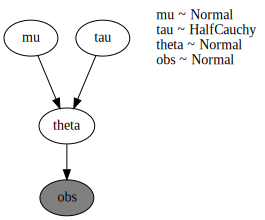

In [24]:
m3_no_reparam = EightSchools(
    seed=258, data=df, group_variables="school", use_reparam=False
)
m3_no_reparam.render()

In [25]:
m3_no_reparam.sample()
m3_no_reparam.mcmc.print_summary(0.9, exclude_deterministic=False)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      4.45      3.28      4.49     -0.89      9.88    577.17      1.01
       tau      4.41      3.20      3.49      0.78      8.91    344.83      1.01
  theta[0]      6.74      6.04      6.20     -2.28     16.18    917.54      1.00
  theta[1]      5.13      5.00      5.03     -2.79     13.32   1018.70      1.01
  theta[2]      3.80      5.77      4.06     -4.90     13.43   1098.91      1.00
  theta[3]      4.77      5.19      4.77     -2.96     13.43   1257.28      1.00
  theta[4]      3.58      5.20      3.94     -4.82     12.16   1152.23      1.00
  theta[5]      3.92      5.16      4.14     -3.84     12.53   1052.61      1.00
  theta[6]      6.75      5.44      6.17     -1.80     15.33    809.55      1.00
  theta[7]      5.18      5.74      4.96     -3.73     14.46   1413.14      1.01

Number of divergences: 71


### Arviz data with plates

This example demonstrates the use of arviz data with plates.
We can just go ahead and generate with the default settings, but then dimensions will not be labelled:

In [26]:
m3.generate_arviz_data()
m3.arviz_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

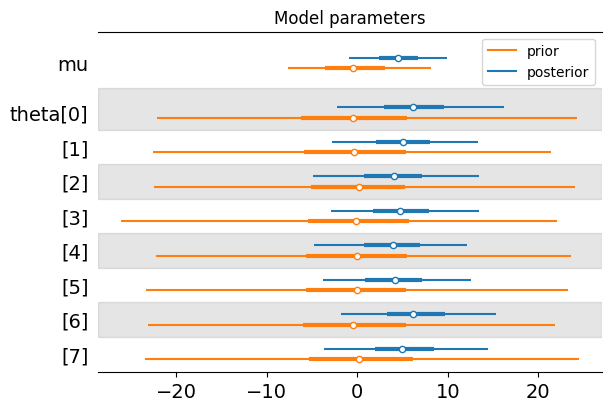

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout="constrained")
ax = az.plot_forest(
    [m3.arviz_data["posterior"], m3.arviz_data["prior"]],
    model_names=["posterior", "prior"],
    kind="forestplot",
    var_names=["mu", "theta"],
    hdi_prob=0.9,
    combined=True,
    ridgeplot_overlap=1.5,
    ax=ax,
)
ax[0].set_title("Model parameters")
plt.show()

This is nice, but we only have the index of the school (0-7) and not its label (A-H).
We can be more explicit about the correspondence between dimensions and labels by using the `dims` argument of `generate_arviz_data`:

In [28]:
m3.generate_arviz_data(dims={"theta": ["school"]})
m3.arviz_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

Now we get automatic labels:

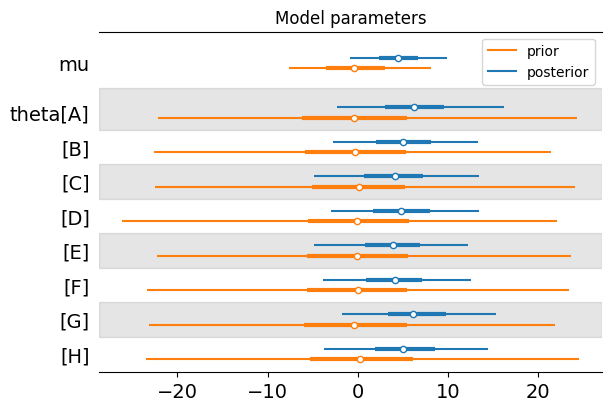

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout="constrained")
ax = az.plot_forest(
    [m3.arviz_data["posterior"], m3.arviz_data["prior"]],
    model_names=["posterior", "prior"],
    kind="forestplot",
    var_names=["mu", "theta"],
    hdi_prob=0.9,
    combined=True,
    ridgeplot_overlap=1.5,
    ax=ax,
)
ax[0].set_title("Model parameters")
plt.show()